# Pre-Modelization

## 1. Data Collection

In [ ]:
import kagglehub
import pandas as pd

In [ ]:
# Download latest version
path = kagglehub.dataset_download("saurabhshahane/ecommerce-text-classification")

print("Path to dataset files:", path)

print("List files:")
!ls {path}

100%|██████████| 7.86M/7.86M [00:01<00:00, 7.65MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/saurabhshahane/ecommerce-text-classification/versions/76
List files:
ecommerceDataset.csv


In [ ]:

filepath = f"{path}/ecommerceDataset.csv"
print("filepath:", filepath)

df = pd.read_csv(filepath, header=None)

filepath: /root/.cache/kagglehub/datasets/saurabhshahane/ecommerce-text-classification/versions/76/ecommerceDataset.csv


In [ ]:
df.columns = ["Label", "Text"]

print("Dataset size:", len(df))
df.head()

Dataset size: 50425


,Label,Text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


## 2. Preprocessing

In [ ]:
len(df)

50425

Check null

In [ ]:
df.isna().sum()

,0
Label,0
Text,1


In [ ]:
df = df.dropna()
len(df)

50424

Data classes balancing

In [ ]:
from collections import Counter

label_count = Counter(df['Label'])

for index, label in enumerate(label_count):
    print(f"Class {index}: {label} - {label_count[label]} observations")

Class 0: Household - 19313 observations
Class 1: Books - 11820 observations
Class 2: Clothing & Accessories - 8670 observations
Class 3: Electronics - 10621 observations


In [ ]:
subset_size = 10000

In [ ]:
def keep_column_subset(df, column, value, size):
    val_set_df, new_df = df[df[column] == value], df[df[column] != value]

    subset_df = val_set_df[:size]
    new_df = pd.concat((new_df, subset_df))
    return new_df

In [ ]:
balanced_df = df
for label in label_count:
    balanced_df = keep_column_subset(balanced_df, "Label", label, subset_size)
    print(f"Class {label}:", len(balanced_df[balanced_df["Label"] == label]))

Class Household: 10000
Class Books: 10000
Class Clothing & Accessories: 8670
Class Electronics: 10000


## 3. Representation

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
vocab_size = 10000
seq_len = 120

In [ ]:
label_encoder = LabelEncoder()

X = balanced_df['Text'].values
y = label_encoder.fit_transform(balanced_df['Label'].values)

In [ ]:
labels = label_encoder.classes_
labels

array(['Books', 'Clothing & Accessories', 'Electronics', 'Household'],
      dtype=object)

X

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

X_sequences = tokenizer.texts_to_sequences(X)

In [ ]:
print((list(len(seq) for seq in X_sequences))[:5])

[232, 59, 229, 188, 184]


In [ ]:
X_padded = pad_sequences(X_sequences, maxlen=seq_len)

In [ ]:
print((list(len(seq) for seq in X_padded))[:5])

[120, 120, 120, 120, 120]


y

In [ ]:
y = to_categorical(y, num_classes=len(label_count))

In [ ]:
y[:10]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Recurrent Neural Network (RNN)

## 4. Modelization - RNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [ ]:
rnn_n_units = 64

In [ ]:
rnn_model = Sequential()

rnn_model.add(Embedding(input_dim=vocab_size, output_dim=64))
rnn_model.add(SimpleRNN(rnn_n_units))
rnn_model.add(Dense(32, activation="relu"))
rnn_model.add(Dense(len(label_count), activation="softmax"))

rnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 5. Compilation & Fitting - RNN

In [ ]:
rnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
n_epochs = 5
fitting_batch_size = 32
history = rnn_model.fit(X_train, y_train, epochs=n_epochs, batch_size=fitting_batch_size, validation_split=0.1)

Epoch 1/5
871/871 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.6266 - loss: 0.8564 - val_accuracy: 0.9150 - val_loss: 0.2800
Epoch 2/5
871/871 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.9426 - loss: 0.1929 - val_accuracy: 0.9173 - val_loss: 0.2729
Epoch 3/5
871/871 ━━━━━━━━━━━━━━━━━━━━ 55s 61ms/step - accuracy: 0.9739 - loss: 0.0944 - val_accuracy: 0.9409 - val_loss: 0.2370
Epoch 4/5
871/871 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.9854 - loss: 0.0479 - val_accuracy: 0.9205 - val_loss: 0.2893
Epoch 5/5
871/871 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.9576 - loss: 0.1275 - val_accuracy: 0.9328 - val_loss: 0.2738


In [ ]:
print(f'Train Accuracy: {history.history["accuracy"][-1]}')
print(f'Val Accuracy: {history.history["val_accuracy"][-1]}\n')

print(f'Train Loss: {history.history["loss"][-1]}')
print(f'Val Loss: {history.history["val_loss"][-1]}')

Train Accuracy: 0.9589110016822815
Val Accuracy: 0.9327731132507324

Train Loss: 0.11989486217498779
Val Loss: 0.2737562954425812


In [ ]:
import matplotlib.pyplot as plt

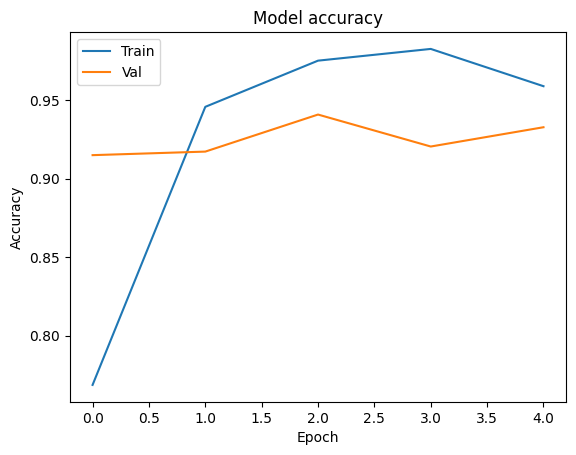

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model accuracy")

plt.show()

## 6. Evaluation - RNN

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
loss, accuracy = rnn_model.evaluate(X_test, y_test, verbose=0)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 0.27424344420433044
Test Accuracy: 0.9327644109725952


In [ ]:
y_pred_logits = rnn_model.predict(X_test)

242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


In [ ]:
import numpy as np

In [ ]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred_logits, axis=1)

print(classification_report(y_true, y_pred, target_names=labels))

                        precision    recall  f1-score   support

                 Books       0.93      0.96      0.95      1961
Clothing & Accessories       0.97      0.91      0.94      1730
           Electronics       0.94      0.92      0.93      2016
             Household       0.90      0.94      0.92      2027

              accuracy                           0.93      7734
             macro avg       0.94      0.93      0.93      7734
          weighted avg       0.93      0.93      0.93      7734



## 7. Test - RNN

In [ ]:
samples = [
    "Dell 19.5V-3.34AMP 65W Laptop Adapter",
    "Women's Stretchable Viscose",
    "Paper Plane Design Framed Wall Hanging",
    "The art of War",
]

samples_seq = tokenizer.texts_to_sequences(samples)
samples_pad = pad_sequences(samples_seq, maxlen=seq_len)

In [ ]:
pred_logits = rnn_model.predict(samples_pad)

preds = np.argmax(pred_logits, axis=1)

for input, output in zip(samples, preds):
    print("Text :", input)
    print("Predicted Label :", output)
    print("Predicted Class :", labels[output])
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Text : Dell 19.5V-3.34AMP 65W Laptop Adapter
Predicted Label : 2
Predicted Class : Electronics

Text : Women's Stretchable Viscose
Predicted Label : 1
Predicted Class : Clothing & Accessories

Text : Paper Plane Design Framed Wall Hanging
Predicted Label : 3
Predicted Class : Household

Text : The art of War
Predicted Label : 0
Predicted Class : Books



# Save and Load Model

In [ ]:
import tensorflow as tf
import json

## H5 file backup

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
tp_base_dir = "/gdrive/MyDrive/ESTIAM/E5/AI-ML-Model-Design/TP-Model-Backup"
model_file_path = f"{tp_base_dir}/rnn_model.h5"
tokenizer_file_path = f"{tp_base_dir}/tokenizer.json"

In [ ]:
with open(tokenizer_file_path, "w") as tokenizer_file:
    tokenizer_json = tokenizer.to_json()
    tokenizer_file.write(json.dumps(tokenizer_json, indent=2))

In [ ]:
rnn_model.save(model_file_path)

In [ ]:
loaded_rnn_model = tf.keras.models.load_model(model_file_path)

In [ ]:
x_id = 0
x = samples_pad[x_id]
x = np.array([x])
x_logits = loaded_rnn_model.predict(x)

preds = np.argmax(x_logits, axis=1)
output = preds[0]

print("Text :", samples[x_id])
print("Predicted Label :", output)
print("Predicted Class :", labels[output])
print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Text : Dell 19.5V-3.34AMP 65W Laptop Adapter
Predicted Label : 2
Predicted Class : Electronics

